# Using Machine Learning Classifers with NLTK

## CUNY DATA 620 Web Analytics

### Fall 2018 Semester Class Project


# Instructions

- Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. 


- Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. 


- Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. 


- How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect? 

Source: Natural Language Processing with Python, exercise 6.10.2.

In [2]:
import nltk
import random
import numpy as np
import pandas as pd
from itertools import repeat
from sklearn.model_selection import train_test_split
import re

# The Data

Using the NLTK's `names` corpus, we will be demonstrating how to create and improve supervised classification models. The corpus contains 2 files called `female.txt` and `male.txt`.

In [3]:
from nltk.corpus import names
names.fileids() # confirm male and female txt files exist

['female.txt', 'male.txt']

Let's import the male & female names, look at the first 20 entries for each and store them together in a variable called `people`. We will normalize the names by changing them to lowercase letters.

In [7]:
# load male and female  name files from nltk.names; store in people list
males, females = [n.lower() for n in names.words('male.txt')], [n.lower() for n in names.words('female.txt')] 

print([male for male in males[:20]])
print([female for female in females[:20]])

people = males + females

['aamir', 'aaron', 'abbey', 'abbie', 'abbot', 'abbott', 'abby', 'abdel', 'abdul', 'abdulkarim', 'abdullah', 'abe', 'abel', 'abelard', 'abner', 'abraham', 'abram', 'ace', 'adair', 'adam']
['abagael', 'abagail', 'abbe', 'abbey', 'abbi', 'abbie', 'abby', 'abigael', 'abigail', 'abigale', 'abra', 'acacia', 'ada', 'adah', 'adaline', 'adara', 'addie', 'addis', 'adel', 'adela']


We have 7944 names in total.

In [8]:
n_people = len(people)
n_people

7944

Next, let's create the variable `gender`, which will contain the gender labels for each of the names. 

In [9]:
# make gender list
gender = list(repeat('male', len(males))) + list(repeat('female', len(females)))

When we plot the frequency of the male and female names, we see that there is a class imbalance between the two labels. There are considerably more females than males.

In [10]:
gender_counts = pd.Series(gender).value_counts()
gender_counts.plot.bar()

Specifically, more than 60% are female. We will want to be cognizant of this class imbalance when we choose the metrics to evaluate the strength of our model. If we simply predicted that every name was female, we would be correct more than 60% of the time. We may also want to consider stratifying the training, development and testing data sets.

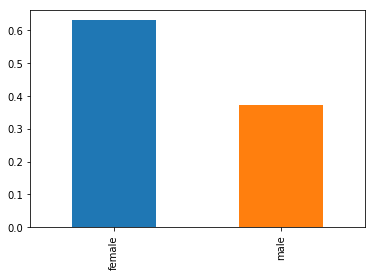

In [12]:
gender_counts.divide(n_people).plot.bar()

# Feature Engineering

## Initial Features

In [36]:
def first1(word):
    return word[0]
def first2(word):
    return word[0:2]
def first3(word):
    return word[0:3] if len(word) > 2 else word[0:2]
 
def last1(word):
    return word[-1]
def last2(word):
    return word[-2:]
def last3(word):
    return word[-3:] if len(word) > 2  else word[-2:]

def vowel_count(word):
    vowels = [letter for letter in word if letter in 'aeiou']
    return len(vowels)

initial_features = [len, first1, first2, first3, last1, last2, last3, vowel_count]

In [38]:
# produce features
def gender_features(word, features):
    """
    function returns dictionary of features
        word: name to extract features from
        args: list of functions
               
    """
    
    gf = {}
    # creates dictionary with the features
    for feature in features:
        gf[feature.__name__] = feature(word)

    return gf

In [42]:
# specify name, and argument list 
print(people[0])
gender_features(people[0], initial_features)

aamir


{'len': 5,
 'first1': 'a',
 'first2': 'aa',
 'first3': 'aam',
 'last1': 'r',
 'last2': 'ir',
 'last3': 'mir',
 'vowel_count': 3}

# Training, Development & Test Sets

Let's partition our data into 3 buckets. We will stratify each bucket in order to maintain our class imbalance and set the random state to 4.

- First, let's set aside 500 observations that will not be used in training or development. We will use this teste set to evaluate the strength of the model.

- Then, let's hold out another 500 observations to use as a development set to do error analysis.

- Finally, we will use the remaining 6944 names to train our model.

In [103]:
# set aside 500 samples for testing
people_dev_train, people_test, gender_dev_train, gender_test = train_test_split(people, 
                                                                        gender, 
                                                                        test_size=500, 
                                                                        stratify=gender, 
                                                                        random_state=4)

# set aside 500 samples for development
people_train, people_devtest, gender_train, gender_devtest = train_test_split(people_dev_train, 
                                                                            gender_dev_train, 
                                                                            test_size=500, 
                                                                            stratify=gender_dev_train,
                                                                            random_state=4)

# list of tuples (name, gender)
train_names = list(zip(people_train, gender_train))
devtest_names = list(zip(people_devtest, gender_devtest))
test_names = list(zip(people_test, gender_test))


We will then apply our features to these 3 sets, keeping in mind that we will need to recreate these if we add new features to our model

In [ ]:
def create_features(names, genders, features):
    """
    function returns list of tuples (name features, gender)
        names: list of names to extract features from
        genders: list of gender values
        features: list of feature functions           
    """    
    return list(zip(map(lambda d: gender_features(d, features), names), genders))

train_set  = create_features(people_train, gender_train, initial_features)
devtest_set = create_features(people_devtest, gender_devtest, initial_features)
test_set = create_features(people_test, gender_test, initial_features)

# Naive Bayes Classification

Let's use the naive Bayes (NB) classifier to build our first model. This model derives its "naiviete" from its independence asssumption. NB assumes that all features are independent of one another, but features within real-world data often contain dependencies. 

In [179]:
# train naive bayes classifier 
nb_classifier = nltk.NaiveBayesClassifier.train(train_set)

The accuracy between the training and development sets is fairly high at .858.

In [178]:
# classifer accuracy on validation set
print(nltk.classify.accuracy(nb_classifier, devtest_set))

0.858


Let's take a look at the likelihood ratios of most important features so far. When the last 2 letters are 'na', the name is 93 times more often female than male.

In [194]:
# look at most informative features
nb_classifier.show_most_informative_features(30)

Most Informative Features
                   last2 = 'na'           female : male   =     93.3 : 1.0
                   last2 = 'ia'           female : male   =     51.8 : 1.0
                   last2 = 'us'             male : female =     35.6 : 1.0
                   last1 = 'a'            female : male   =     34.9 : 1.0
                   last2 = 'sa'           female : male   =     34.2 : 1.0
                   last2 = 'ld'             male : female =     33.9 : 1.0
                   last1 = 'k'              male : female =     30.3 : 1.0
                   last2 = 'do'             male : female =     27.2 : 1.0
                   last3 = 'tta'          female : male   =     25.5 : 1.0
                   last2 = 'rd'             male : female =     25.3 : 1.0
                   last3 = 'ana'          female : male   =     24.7 : 1.0
                   last2 = 'ta'           female : male   =     24.0 : 1.0
                   last2 = 'io'             male : female =     23.9 : 1.0

Next, let's take a look at some of the model's misclassified names.

In [181]:
# look at names that were mis-classified
errors = []
for (name, tag) in devtest_names:
    #print(name)
    prediction = nb_classifier.classify(gender_features(name, initial_features))
    if prediction != tag:
        errors.append((tag, prediction, name))

print('actual, prediction, name: \n')
for x in errors:
    print(x)        

actual, prediction, name: 

('male', 'female', 'llewellyn')
('female', 'male', 'rianon')
('female', 'male', 'michell')
('male', 'female', 'gerrit')
('female', 'male', 'ruthy')
('female', 'male', 'jan')
('female', 'male', 'alyss')
('male', 'female', 'moishe')
('female', 'male', 'hazel')
('female', 'male', 'mei')
('male', 'female', 'michale')
('female', 'male', 'elinor')
('male', 'female', 'martyn')
('male', 'female', 'herculie')
('male', 'female', 'lindsey')
('female', 'male', 'sharron')
('female', 'male', 'terry')
('female', 'male', 'nike')
('female', 'male', 'izabel')
('female', 'male', 'fran')
('female', 'male', 'paige')
('female', 'male', 'olwen')
('female', 'male', 'clary')
('male', 'female', 'jermaine')
('female', 'male', 'tierney')
('male', 'female', 'moise')
('female', 'male', 'berty')
('female', 'male', 'wallie')
('male', 'female', 'seth')
('female', 'male', 'quentin')
('female', 'male', 'leigh')
('male', 'female', 'kenneth')
('male', 'female', 'augustine')
('male', 'female', '

In [184]:
def every_other2_beg(word):
    return word[0] + word[2] if len(word) > 2 else word[0]
def every_other3_beg(word): 
    return every_other2_beg(word) + word[4] if len(word) > 4 else every_other2_beg(word)

# every other end
def every_other2_end(word): 
    return word[-3] + word[-1] if len(word) > 2 else word[-1]
def every_other3_end(word): 
    return word[-5] + every_other2_end(word) if len(word) > 4 else every_other2_end(word)
    
features_v2 = initial_features + [every_other2_beg, every_other3_beg, every_other2_end, every_other3_end]
print(people[0])
gender_features(people[0], features_v2)


aamir


{'len': 5,
 'first1': 'a',
 'first2': 'aa',
 'first3': 'aam',
 'last1': 'r',
 'last2': 'ir',
 'last3': 'mir',
 'vowel_count': 3,
 'every_other2_beg': 'am',
 'every_other3_beg': 'amr',
 'every_other2_end': 'mr',
 'every_other3_end': 'amr'}

In [185]:


people_train_v2, people_devtest_v2, gender_train_v2, gender_devtest_v2 = train_test_split(people_dev_train, 
                                                                            gender_dev_train, 
                                                                            test_size=500, 
                                                                            stratify=gender_dev_train,
                                                                            random_state=5)

# list of tuples (name, gender)
train_names_v2 = list(zip(people_train_v2, gender_train_v2))
devtest_names_v2 = list(zip(people_devtest_v2, gender_devtest_v2))

# feature sets
train_set_v2  = create_features(people_train_v2, gender_train_v2, features_v2)
devtest_set_v2 = create_features(people_devtest_v2, gender_devtest_v2, features_v2)

In [186]:
# train naive bayes classifier 
nb_classifier_v2 = nltk.NaiveBayesClassifier.train(train_set_v2)
# classifer accuracy on validation set
print(nltk.classify.accuracy(nb_classifier_v2, devtest_set_v2))
# look at most informative features
nb_classifier_v2.show_most_informative_features(30)


0.82
Most Informative Features
                   last2 = 'na'           female : male   =     94.1 : 1.0
        every_other2_end = 'la'           female : male   =     79.5 : 1.0
        every_other2_end = 'ea'           female : male   =     64.1 : 1.0
        every_other2_end = 'ia'           female : male   =     44.8 : 1.0
                   last2 = 'ia'           female : male   =     38.5 : 1.0
                   last2 = 'ld'             male : female =     37.2 : 1.0
                   last2 = 'us'             male : female =     35.6 : 1.0
                   last1 = 'a'            female : male   =     33.6 : 1.0
        every_other3_end = 'aia'          female : male   =     32.9 : 1.0
                   last2 = 'sa'           female : male   =     32.6 : 1.0
                   last1 = 'k'              male : female =     30.8 : 1.0
                   last3 = 'nne'          female : male   =     29.8 : 1.0
        every_other2_end = 'aa'           female : male   =     25.6 

### References
http://www.nltk.org/howto/corpus.html

In [73]:
# show number of mislabeled names 
print "Mislabeled names: ", len(errors)

Mislabeled names:  202
